In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import GARCH, ARCH, Naive, AutoARIMA
from datasetsforecast.losses import mae
import warnings

In [31]:
warnings.filterwarnings("ignore")

In [32]:
tickers = ['SPY', 'MSFT', 'AAPL', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'META', 'NKE', 'NFLX'] 
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1mo')
df.head()

[                       0%%                      ]

[*********************100%%**********************]  10 of 10 completed


Price       Adj Close                                               \
Ticker           AAPL       AMZN       GOOG        META       MSFT   
Date                                                                 
2018-01-01  39.477051  72.544502  58.430511  186.506729  88.362892   
2018-02-01  41.997574  75.622498  55.173714  177.954330  87.209625   
2018-03-01  39.720875  72.366997  51.530861  159.462311  85.283272   
2018-04-01  39.124275  78.306503  50.808681  171.647278  87.385681   
2018-05-01  44.240318  81.481003  54.187836  191.386719  92.356728   

Price                                                               ...  \
Ticker            NFLX        NKE      NVDA         SPY       TSLA  ...   
Date                                                                ...   
2018-01-01  270.299988  63.624386  6.079518  253.339890  23.620667  ...   
2018-02-01  291.380005  62.514542  5.985531  244.128357  22.870667  ...   
2018-03-01  295.350006  61.964310  5.731614  236.489517  17.742001  ...   
2018-04-01  312.459991  63.975887  5.566043  238.663788  19.593332  ...   
2018-05-01  351.600006  67.165771  6.241445  244.465546  18.982000  ...   

Price           Volume                                               \
Ticker            AAPL        AMZN       GOOG       META       MSFT   
Date                                                                  
2018-01-01  2638717600  1927424000  574768000  495655700  574258400   
2018-02-01  3711577200  2755680000  847640000  516251600  725663300   
2018-03-01  2854910800  2608002000  907066000  996201700  750754800   
2018-04-01  2664617200  2598392000  834318000  750072700  668130700   
2018-05-01  2483905200  1432310000  636988000  401144100  509417900   

Price                                                                  
Ticker           NFLX        NKE         NVDA         SPY        TSLA  
Date                                                                   
2018-01-01  238377600  157812200  11456216000  1985506700  1864072500  
2018-02-01  184585800  160317000  14915528000  2923722000  1637850000  
2018-03-01  263449400  174066700  14118440000  2323561800  2359027500  
2018-04-01  262006000  158981900  11144008000  1998466500  2854662000  
2018-05-01  142050800  129566300  11978240000  1606397200  2333671500  

[5 rows x 60 columns]

In [33]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index()
df.head()

Ticker,Date,SPY,MSFT,AAPL,GOOG,AMZN,TSLA,NVDA,META,NKE,NFLX
0,2018-01-01,253.339890,88.362892,39.477051,58.430511,72.544502,23.620667,6.079518,186.506729,63.624386,270.299988
1,2018-02-01,244.128357,87.209625,41.997574,55.173714,75.622498,22.870667,5.985531,177.954330,62.514542,291.380005
2,2018-03-01,236.489517,85.283272,39.720875,51.530861,72.366997,17.742001,5.731614,159.462311,61.964310,295.350006
3,2018-04-01,238.663788,87.385681,39.124275,50.808681,78.306503,19.593332,5.566043,171.647278,63.975887,312.459991
4,2018-05-01,244.465546,92.356728,44.240318,54.187836,81.481003,18.982000,6.241445,191.386719,67.165771,351.600006


In [34]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices


,unique_id,ds,y
0,SPY,2018-01-01,253.339890
1,SPY,2018-02-01,244.128357
2,SPY,2018-03-01,236.489517
3,SPY,2018-04-01,238.663788
4,SPY,2018-05-01,244.465546
...,...,...,...
595,NFLX,2022-08-01,223.559998
596,NFLX,2022-09-01,235.440002
597,NFLX,2022-10-01,291.880005
598,NFLX,2022-11-01,305.529999


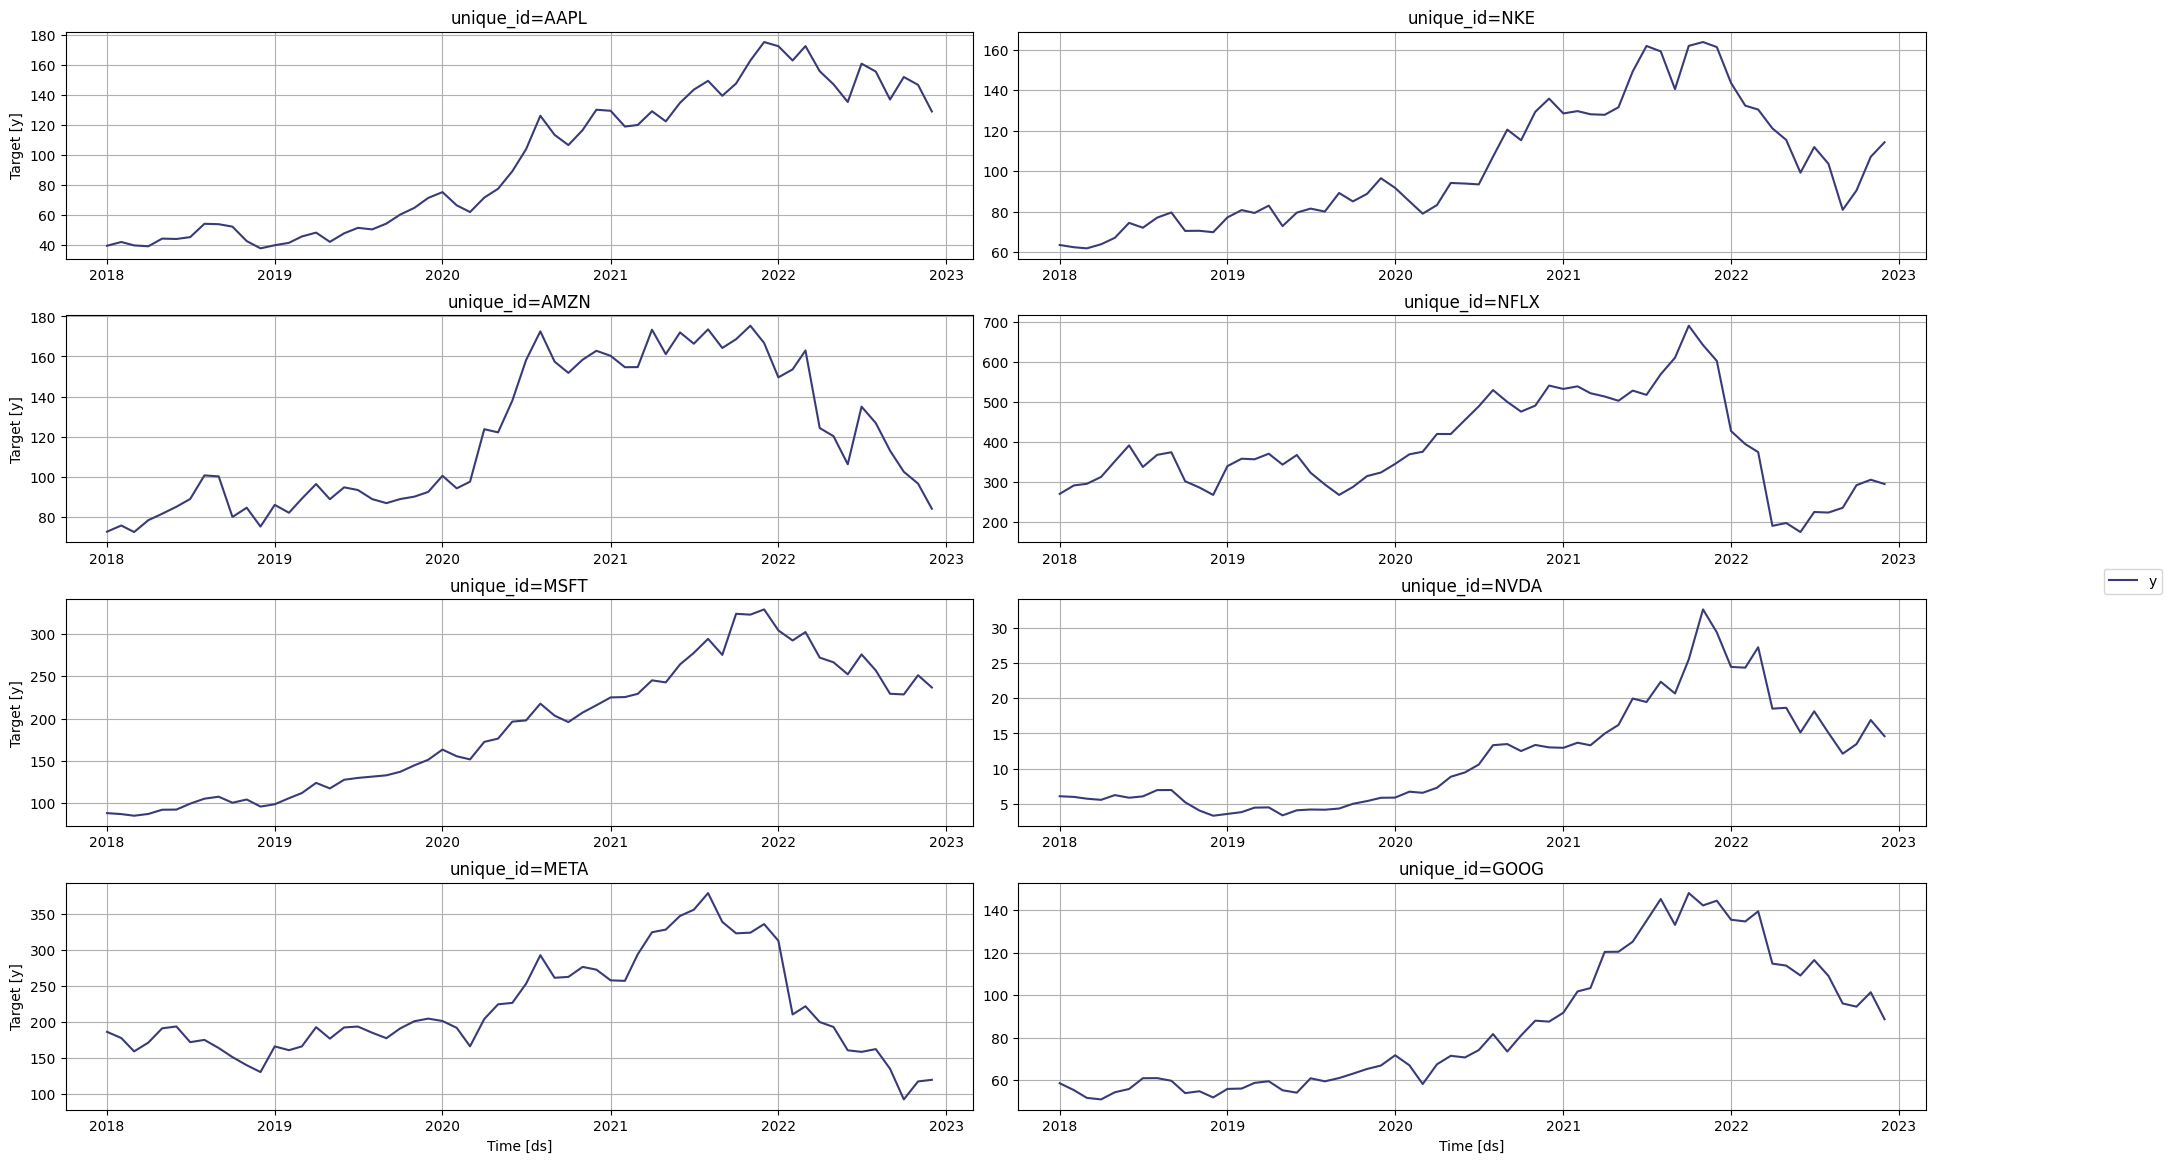

In [35]:
StatsForecast.plot(prices)

In [36]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns


,unique_id,ds,y
0,SPY,2018-01-01,NaN
1,SPY,2018-02-01,-0.037038
2,SPY,2018-03-01,-0.031790
3,SPY,2018-04-01,0.009152
4,SPY,2018-05-01,0.024019
...,...,...,...
595,NFLX,2022-08-01,-0.005976
596,NFLX,2022-09-01,0.051776
597,NFLX,2022-10-01,0.214887
598,NFLX,2022-11-01,0.045705


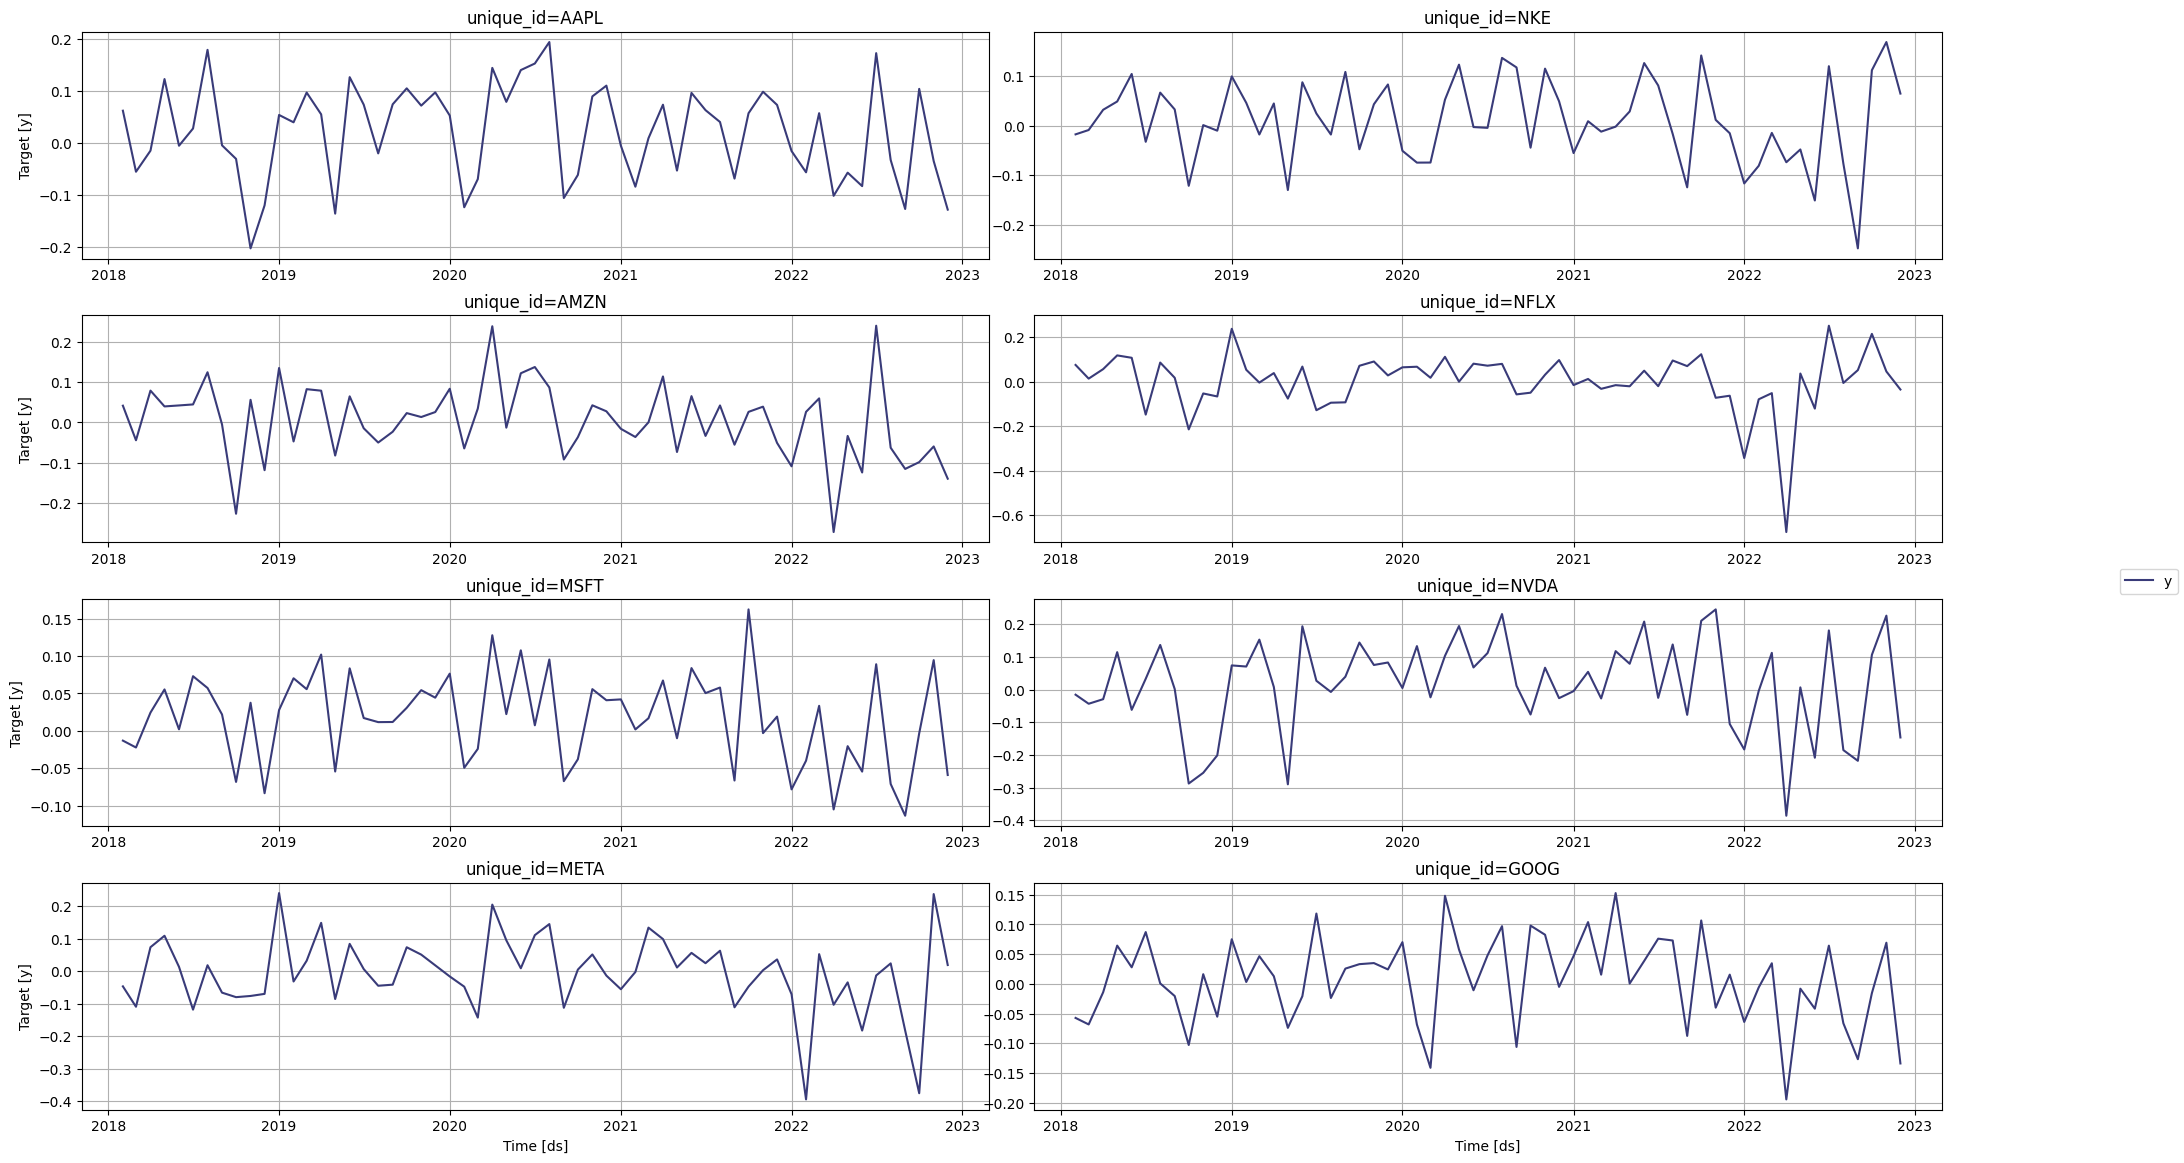

In [37]:
StatsForecast.plot(returns)

In [38]:
models = [ARCH(1), ARCH(2), GARCH(1,1), GARCH(1,2), GARCH(2,2), GARCH(2,1), AutoARIMA(), Naive()]

sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'MS',
    n_jobs = -1
)

In [39]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

In [40]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()


,unique_id,ds,cutoff,actual,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",AutoARIMA,Naive
0,AAPL,2022-01-01,2021-12-01,-0.015837,0.142419,0.144028,0.142954,0.141685,0.141685,0.144016,0.018206,0.073061
1,AAPL,2022-02-01,2021-12-01,-0.056855,-0.056894,-0.057166,-0.056389,-0.058787,-0.058788,-0.057158,0.000000,0.073061
2,AAPL,2022-03-01,2021-12-01,0.057156,-0.045900,-0.046483,-0.047513,-0.045713,-0.045712,-0.046479,0.000000,0.073061
3,AAPL,2022-04-01,2022-03-01,-0.102178,0.138666,0.140218,0.199221,0.136122,0.238860,0.140215,0.027441,0.057156
4,AAPL,2022-05-01,2022-03-01,-0.057505,-0.056014,-0.056269,-0.076285,-0.057080,-0.092237,-0.056269,0.000000,0.057156


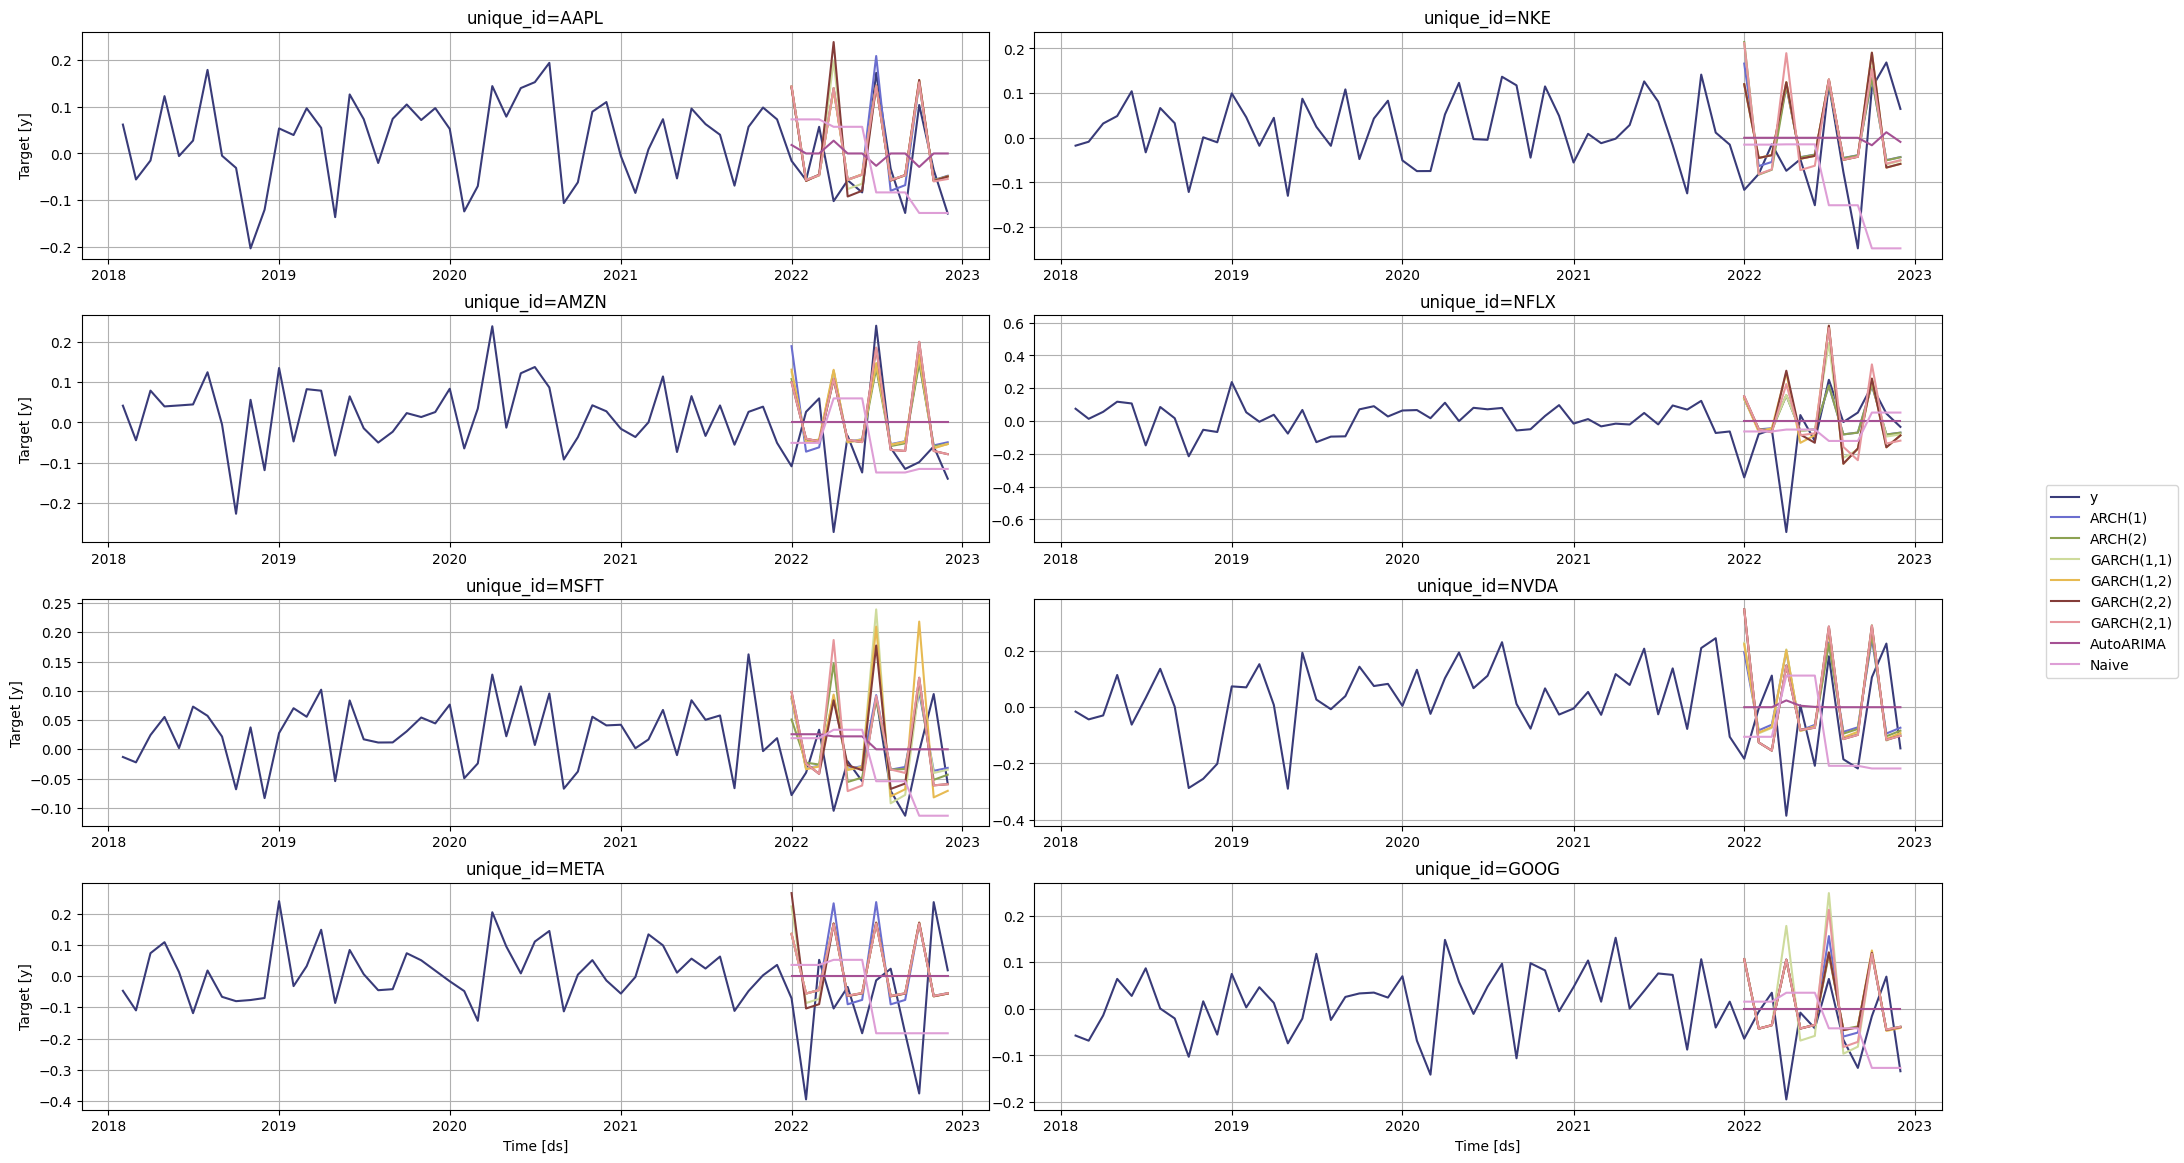

In [41]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [42]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)


mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae

,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",AutoARIMA,Naive
unique_id,,,,,,,,
AAPL,0.069515,0.068929,0.073931,0.069186,0.077643,0.068817,0.089614,0.110425
AMZN,0.127390,0.113613,0.118859,0.119930,0.109910,0.109910,0.111362,0.115189
GOOG,0.094803,0.093750,0.110861,0.094520,0.094057,0.098463,0.068790,0.083233
META,0.210777,0.198892,0.206907,0.199711,0.210372,0.198890,0.141001,0.185346
MSFT,0.070767,0.074460,0.079072,0.088418,0.075918,0.084334,0.071245,0.086951
NFLX,0.159386,0.159528,0.199623,0.232477,0.230076,0.230770,0.159618,0.167421
NKE,0.102840,0.107165,0.103227,0.107176,0.107177,0.115534,0.107258,0.160405
NVDA,0.189459,0.207875,0.199005,0.197036,0.211928,0.211927,0.165312,0.215289
SPY,0.064091,0.058584,0.071395,0.057052,0.070049,0.073213,0.060939,0.089012
